In [1]:
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib
%matplotlib inline
from ovejero import model_trainer, data_tools, bnn_inference
import corner
import os

def NOTIMPLEMENTED():
    raise NotImplementedError('Must specify config/save path')

2023-09-14 02:34:37.853680: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-14 02:34:39.367755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/parlange/anaconda3/envs/bnn/lib/python3.11/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


# Testing the Performance of a Model That Has Been Fit

__Author:__ Sebastian Wagner-Carena

__Last Run:__ 08/04/2020

__Goals:__ Learn how to test the performance of a trained model on the validation set.

__Before running this notebook:__ Run the Train_Toy_Model notebook to understand how to train a model. Then train a model with whatever configuration you want. You will have to add the path to the config file in this notebook.

To start, all we have to do is load up our model weights and run it on the validation set. Thankfully, that's pretty easy to do with the BNN inference class. If you don't have a GPU, generating samples for the full validation set can be time consuming (30-40 minutes for 1000 samples). However, by specifying a save path for the samples we only need to do this once.

In [2]:
# First specify the config path
config_path = '/home/parlange/ovejero/demos/diag.json'

# Check that the config has what you need
cfg = model_trainer.load_config(config_path)

# The InferenceClass will do all the heavy lifting of preparing the model from the configuration file,
# initializing the validation dataset, and providing outputs correctly marginalized over the BNN uncertainties.
bnn_infer = bnn_inference.InferenceClass(cfg)

# Now we just have to ask the InferenceClass to spin up some samples from our BNN. The more samples, the more
# accurate our plots and metrics will be. The right value to use unfortunately requires a bit of trial and error.
# 1000 is a good starting point though.
num_samples = 1000
sample_save_dir = r'/home/parlange/ovejero/saved/'
bnn_infer.gen_samples(num_samples,sample_save_dir=sample_save_dir)
#bnn_infer.gen_samples(num_samples)

2023-09-14 02:34:43.070114: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-14 02:34:43.133378: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-09-14 02:34:43.319648: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-09-14 02:34:43.405655: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free s

Is model built: True
No weights found. Saving new weights to /home/parlange/ovejero/demos/test_model.h5
TFRecord found at /home/parlange/ovejero/demos/../test/test_data/tf_record_test_val
Loading samples from /home/parlange/ovejero/saved/


Now that we set up our infastructure, the first thing we want to do is inspect the statistics of our network's performance over the validation set.

In [3]:
bnn_infer.report_stats()

Parameter, RMSE, Median Abs Error, Median Std
external_shear_g1 0.06947807479070514 0.1296864530617664
external_shear_g2 26.71044469361513 488.74684178675574
lens_mass_center_x 18.130884987948573 658.8868709246401
lens_mass_center_y 0.8773273991099602 44.66286233462552
lens_mass_e1 9.113025916456355 0.3527716468854313
lens_mass_e2 3.8855039709894843 50.34572419094836
lens_mass_gamma 7.249709866489112 80.47920791942491
lens_mass_theta_E_log 0.8246195766052538 0.13287045940606945


We can also inspect a coverage plot of our parameters. If our model is performing well, we expect our data to roughly follow the 68-95-99.7 rule.

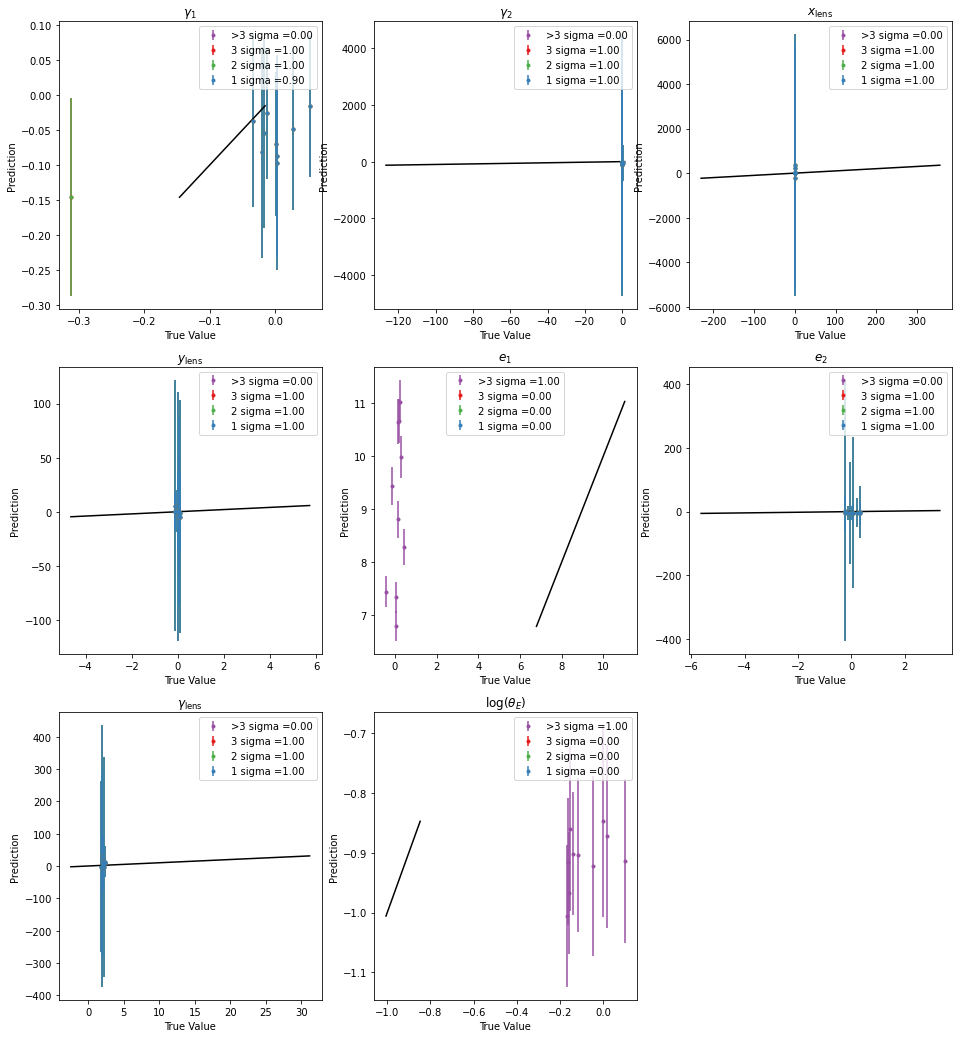

In [4]:
bnn_infer.gen_coverage_plots()

Another good check is to see the posterior of some example images.

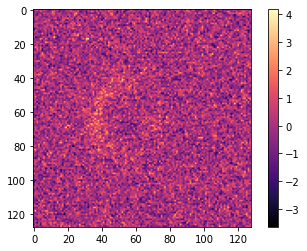

external_shear_g1 0.002771395
external_shear_g2 -0.008360115
lens_mass_center_x -0.12213176
lens_mass_center_y 0.010332832
lens_mass_e1 0.21592133
lens_mass_e2 0.07800379
lens_mass_gamma 1.8834403
lens_mass_theta_E_log -0.0027924478


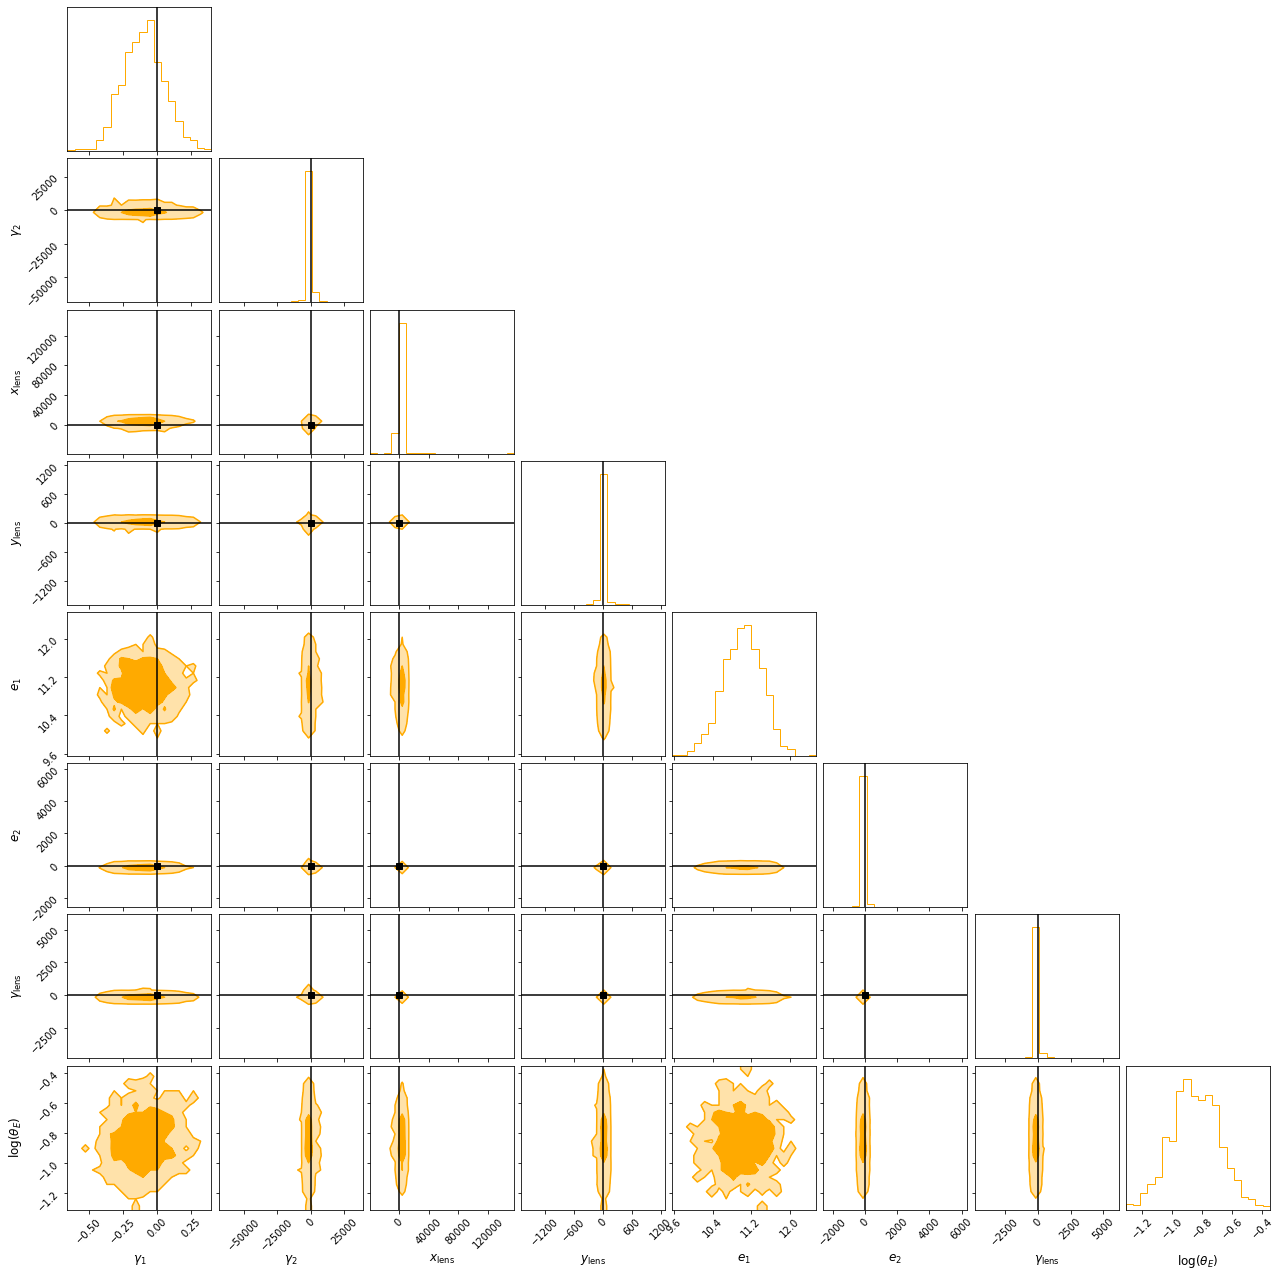

In [5]:
image_index = 5
bnn_infer.plot_posterior_contours(image_index)

It's important to understand where our uncertainty is coming from. We can inspect wether our uncertainty is dominated by aleatoric or epistemic sources. 

/home/parlange/ovejero/ovejero/bnn_inference.py:514: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0]+self.final_params_print_names)
/home/parlange/ovejero/ovejero/bnn_inference.py:515: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0]+self.final_params_print_names)


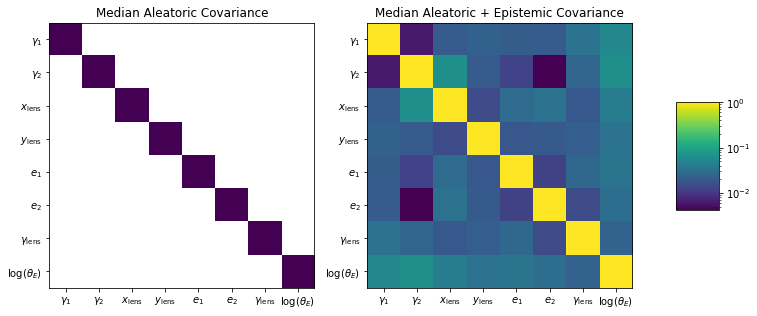

/home/parlange/ovejero/ovejero/bnn_inference.py:529: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[0].set_xticklabels([0]+self.final_params_print_names)
/home/parlange/ovejero/ovejero/bnn_inference.py:530: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.axes[0].set_yticklabels([0]+self.final_params_print_names)


[<Figure size 864x360 with 3 Axes>, <Figure size 432x432 with 2 Axes>]

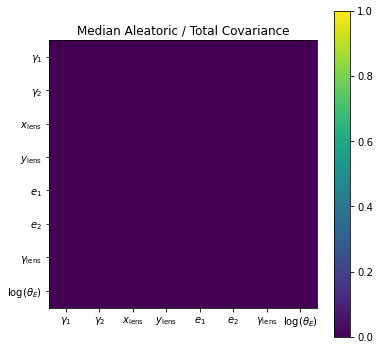

In [6]:
bnn_infer.comp_al_ep_unc()

At the end what we want our network's posterior to be well calibrated. That means that the truth should be a representative draw from the distribution we're predicting. The exact sampling that goes into the calibration plot is complicated, but the x axis repesents how much of the data the model expects to fall within a certain region of our posterior, and the y axis represents how much data actually falls within that region. Ideally this would be a straight line (y=x), but in practice our model is likely to be overconfident, underconfident, or some combination of both. The lower right hand corner of our plot represents overconfidence, and the upper right hand corner represents underconfidence.

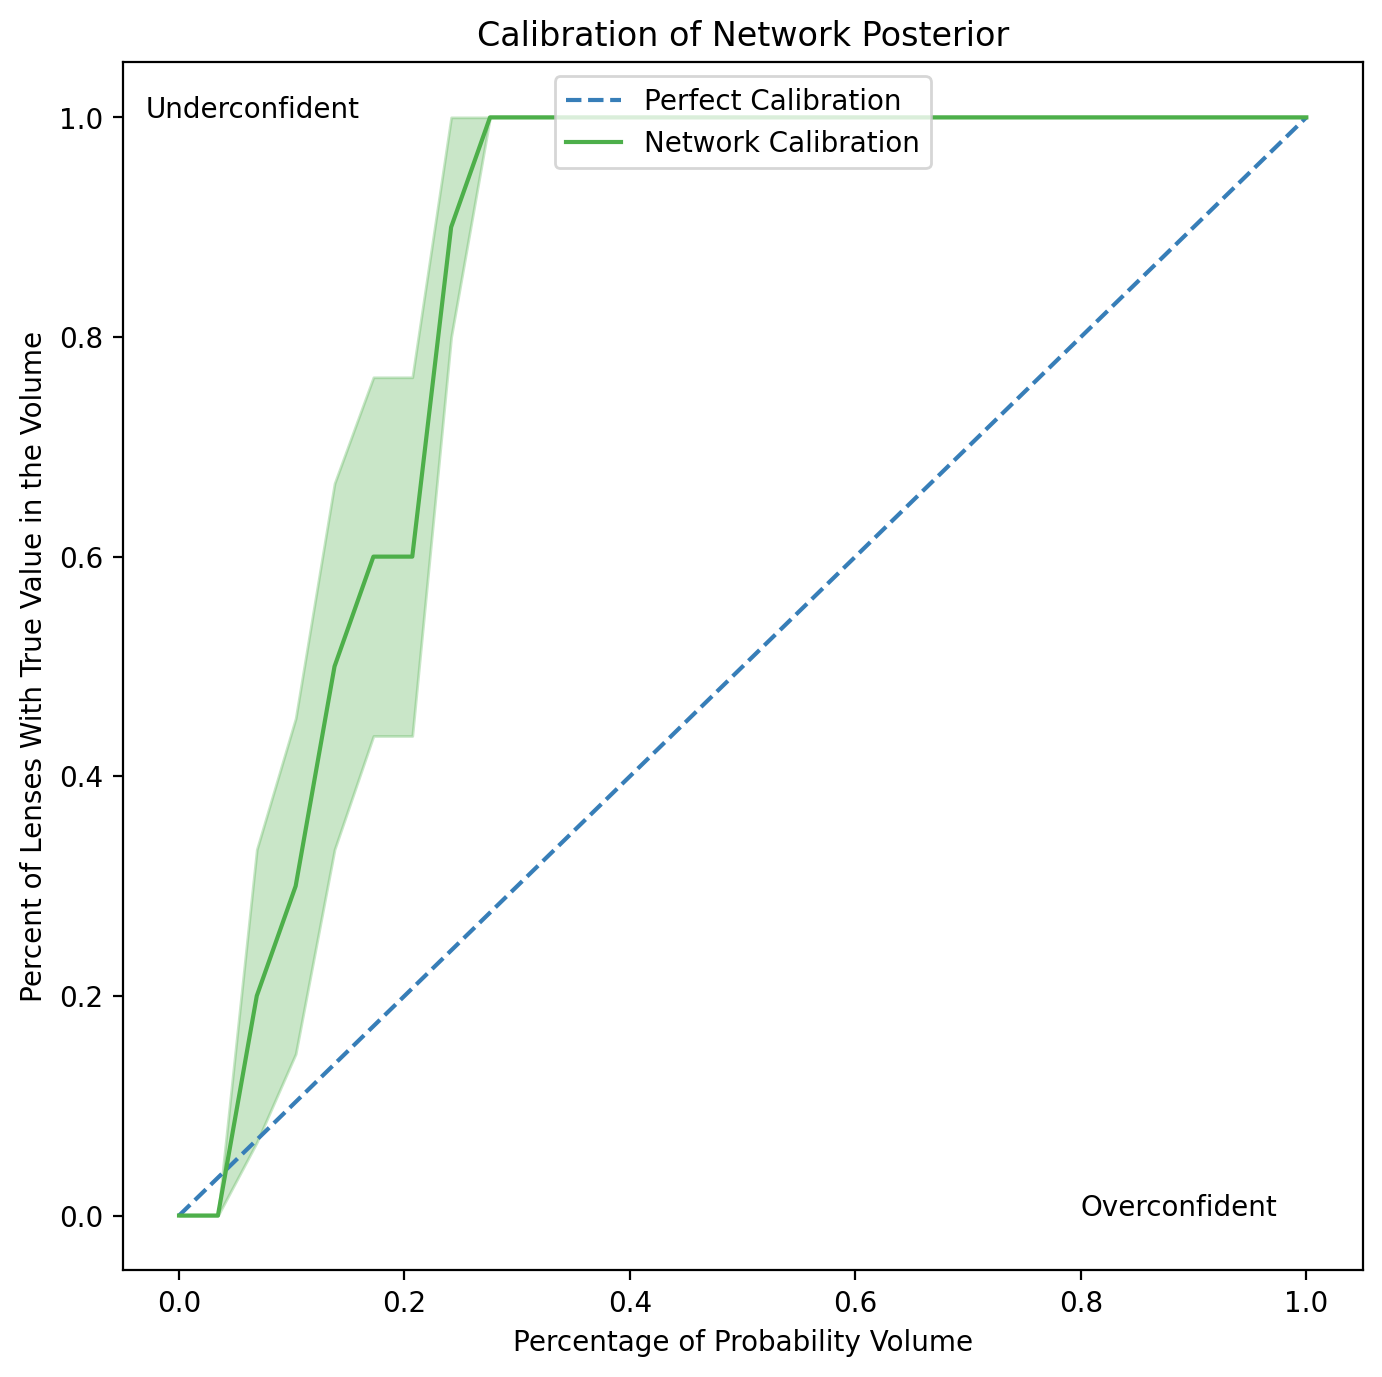

In [7]:
color_map = ["#377eb8", "#4daf4a"]
n_perc_points = 30
fig = bnn_infer.plot_calibration(color_map=color_map,n_perc_points=n_perc_points)

 ## Understanding the Calibration Plot

Throughout our paper we argue that the calibration plot is the best metric to asses the quality of the BNN posterior. Here, we include a few examples to give a better feel for the calibration plot. We focus on toy 2D models since those are easy to visualize and conceptualize. We can start with a biased 2D posterior prediction.

In [8]:
# First we'll make a class to generate our comparison
matplotlib.rcParams.update({'font.size': 13})
def plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws,
                              fit_guass_data=False):
    bnn_toy = bnn_inference.InferenceClass(cfg)
    # We generate our toy data 
    data = np.random.multivariate_normal(data_mean,data_cov,(toy_batch_size))

    # Now we generate our posterior means and covariances
    post_samples = np.random.multivariate_normal(post_mean,post_cov,(n_draws,toy_batch_size))

    # We change our bnn inference instance to have these values
    bnn_toy.samples_init = True
    bnn_toy.y_pred = np.mean(post_samples,axis=0)
    bnn_toy.predict_samps = post_samples
    bnn_toy.y_test = data
    
    # We can visualize the true data and the posterior, and compare that to the calibration plot.
    color_map=["#377eb8", "#4daf4a"]
    fig = corner.corner(post_samples.reshape(-1,2),bins=20,labels=['x','y'],show_titles=False, plot_datapoints=False,
                  label_kwargs=dict(fontsize=15),levels=[0.68,0.95],dpi=200, 
                  color=color_map[1],fill_contours=True,range=[[-6,6],[-6,6]])
    fig.axes[2].plot(data[:,0],data[:,1],'.',c=color_map[0],alpha=0.1)
    post_line = mlines.Line2D([], [], color=color_map[0], label='True Posterior')
    data_line = mlines.Line2D([], [], color=color_map[1], label='Inferred Posterior')
    plt.legend(handles=[post_line,data_line], bbox_to_anchor=(0.05, 1.0, 1., .0), loc=4,fontsize=12)
    plt.show()
    
    cal_fig = bnn_toy.plot_calibration(n_perc_points=30,title='',
                                       legend=['Perfect Calibration','Inferred Posterior Calibration'])
    
    return (fig,cal_fig)

2023-09-14 02:36:11.769010: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.
2023-09-14 02:36:11.836078: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 268435456 exceeds 10% of free system memory.


Is model built: True
Loaded weights /home/parlange/ovejero/demos/test_model.h5
TFRecord found at /home/parlange/ovejero/demos/../test/test_data/tf_record_test_val


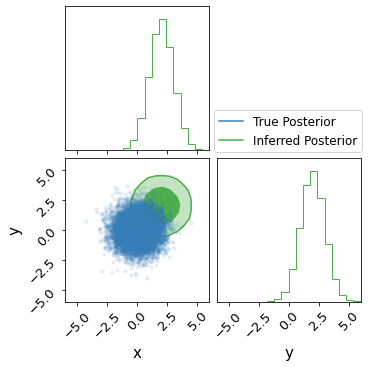

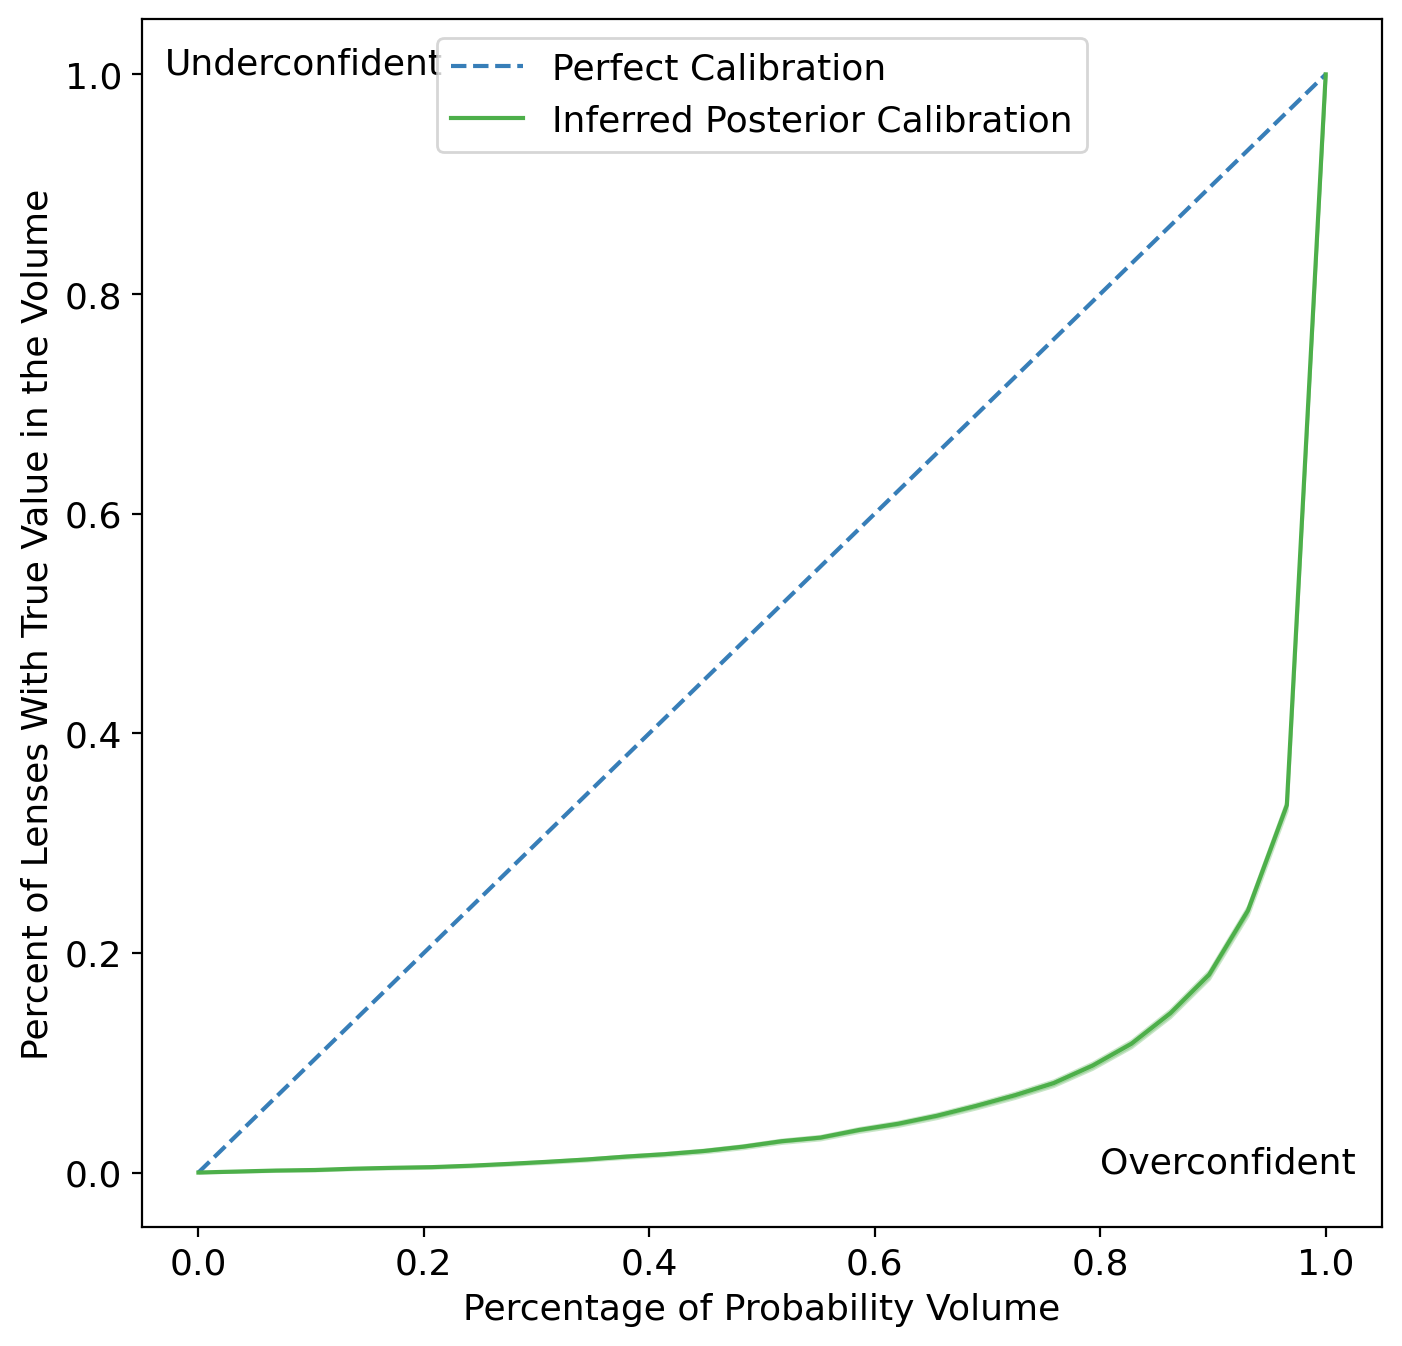

FileNotFoundError: [Errno 2] No such file or directory: '../paper/figures/appendix/offset_corn.pdf'

In [9]:
# We start with our offset posterior
data_mean = np.zeros(2)
data_cov = np.eye(2)
toy_batch_size = 10000
n_draws = 1000
post_mean = np.ones(2)*2
post_cov=np.eye(2)
post_fig, cal_fig = plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws)
post_fig.savefig('../paper/figures/appendix/offset_corn.pdf')
cal_fig.savefig('../paper/figures/appendix/offset_cal.pdf')

The posterior we're predicting is offset from the truth, so our model is consistently overconfident. We can repeat the exercise with a posterior that is correctly centered but has a much tighter contour. We still expect our model to be overconfident.

In [ ]:
data_mean = np.zeros(2)
data_cov = np.eye(2)
toy_batch_size = 10000
n_draws = 1000
post_mean = np.zeros(2)
post_cov=np.eye(2)*0.3
_ = plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws = 1000)

Once again, our model is overconfident. We can similary see what happens when our model is underconfident by expanding our contours.

In [ ]:
data_mean = np.zeros(2)
data_cov = np.eye(2)
toy_batch_size = 10000
n_draws = 1000
post_mean = np.zeros(2)
post_cov=np.eye(2)*3
post_fig, cal_fig = plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws)
post_fig.savefig('../paper/figures/appendix/underconf_corn.pdf')
cal_fig.savefig('../paper/figures/appendix/underconf_cal.pdf')

The model posterior here is underconfident - almost 90% of the data falls within the 1 sigma countour. We can look at a more realistic example - a Gaussian posterior with no covariance trying to fit data with covariance.

Is model built: True
Loaded weights /home/parlange/ovejero/demos/test_model.h5
TFRecord found at /home/parlange/ovejero/demos/../test/test_data/tf_record_test_val


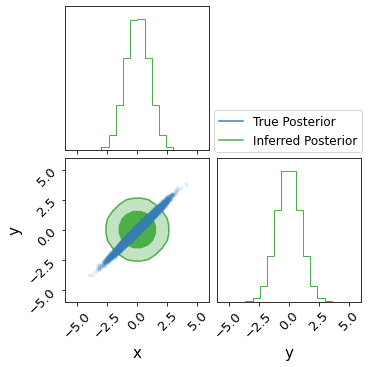

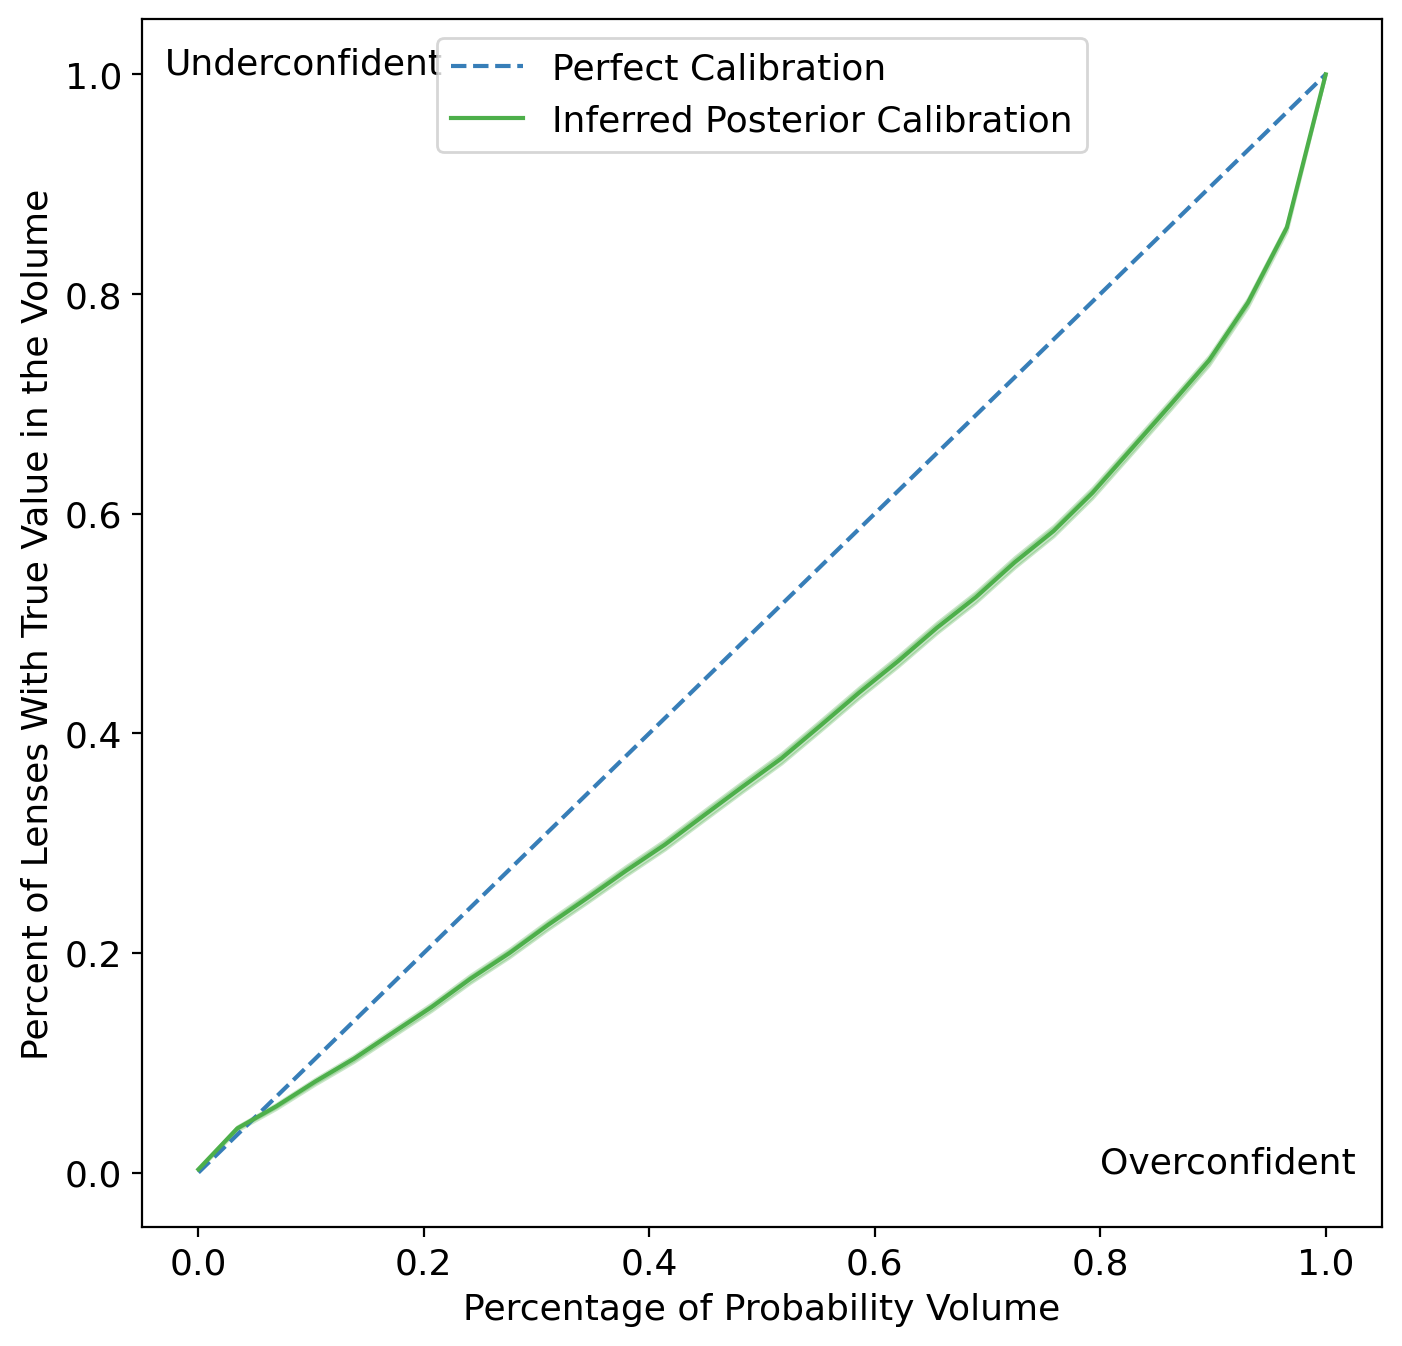

In [10]:
# We start with our offset posterior
data_mean = np.zeros(2)
data_cov = np.array([[1,0.99],[0.99,1]])
toy_batch_size = 10000
n_draws = 1000
post_mean = np.zeros(2)
post_cov=np.diag(np.std(np.random.multivariate_normal(data_mean,data_cov,(toy_batch_size)),axis=0))
_ = plot_toy_model_calibration(data_mean,data_cov,post_mean,post_cov,toy_batch_size,n_draws)

This comes off mostly as overconfident by our network - it's not capturing the extreme covariance in the data, causing the networks contours to assign too little probabilistic weight to the tails.

Another issue our network may have is that the posterior we pick is not sufficiently multimodal to capture the true distribution of the data (or the multimodality is poorly tuned). We can see what this looks like by fitting a full covariance matrix posterior to multimodal data.

In [13]:
# First we'll make a class to generate our comparison
def plot_toy_model_calibration_gm(data_means,data_covs,post_mean,post_cov,toy_batch_size,ps,n_draws,
                              fit_guass_data=False):
    bnn_toy = bnn_inference.InferenceClass(cfg)
    # We generate our toy data 
    data = []
    for dmi in range(len(data_means)):
        data.append(np.random.multivariate_normal(data_means[dmi],data_covs[dmi],(int(toy_batch_size*ps[dmi]))))
    data = np.concatenate(data,axis=0)
    
    if fit_guass_data == True:
        post_mean = np.mean(data,axis=0)
        post_cov=np.diag(np.std(data,axis=0))

    # Now we generate our posterior means and covariances
    post_samples = np.random.multivariate_normal(post_mean,post_cov,(n_draws,toy_batch_size))

    # We change our bnn inference instance to have these values
    bnn_toy.samples_init = True
    bnn_toy.y_pred = np.mean(post_samples,axis=0)
    bnn_toy.predict_samps = post_samples
    bnn_toy.y_test = data
    
    # We can visualize the true data and the posterior, and compare that to the calibration plot.
    color_map=["#377eb8", "#4daf4a"]
    fig = corner.corner(post_samples.reshape((-1,2)),bins=20,labels=['x','y'],show_titles=False, 
                        plot_datapoints=False,label_kwargs=dict(fontsize=15),levels=[0.68,0.95],dpi=1600, 
                        color=color_map[1],fill_contours=True,range=[[-6,6],[-6,6]])
    fig.axes[2].plot(data[:,0],data[:,1],'.',c=color_map[0],alpha=0.1)
    post_line = mlines.Line2D([], [], color=color_map[0], label='True Posterior')
    data_line = mlines.Line2D([], [], color=color_map[1], label='Inferred Posterior')
    plt.legend(handles=[data_line,post_line], bbox_to_anchor=(0.05, 1.0, 1., .0), loc=4,fontsize=12.0)
    plt.show()
    cal_fig = bnn_toy.plot_calibration(n_perc_points=30,title='',
                                       legend=['Perfect Calibration','Inferred Posterior Calibration'])
    return (fig,cal_fig)

Is model built: True
Loaded weights /home/parlange/ovejero/demos/test_model.h5
TFRecord found at /home/parlange/ovejero/demos/../test/test_data/tf_record_test_val


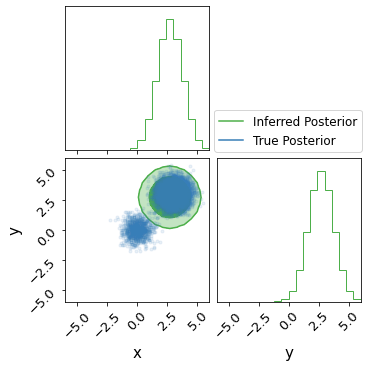

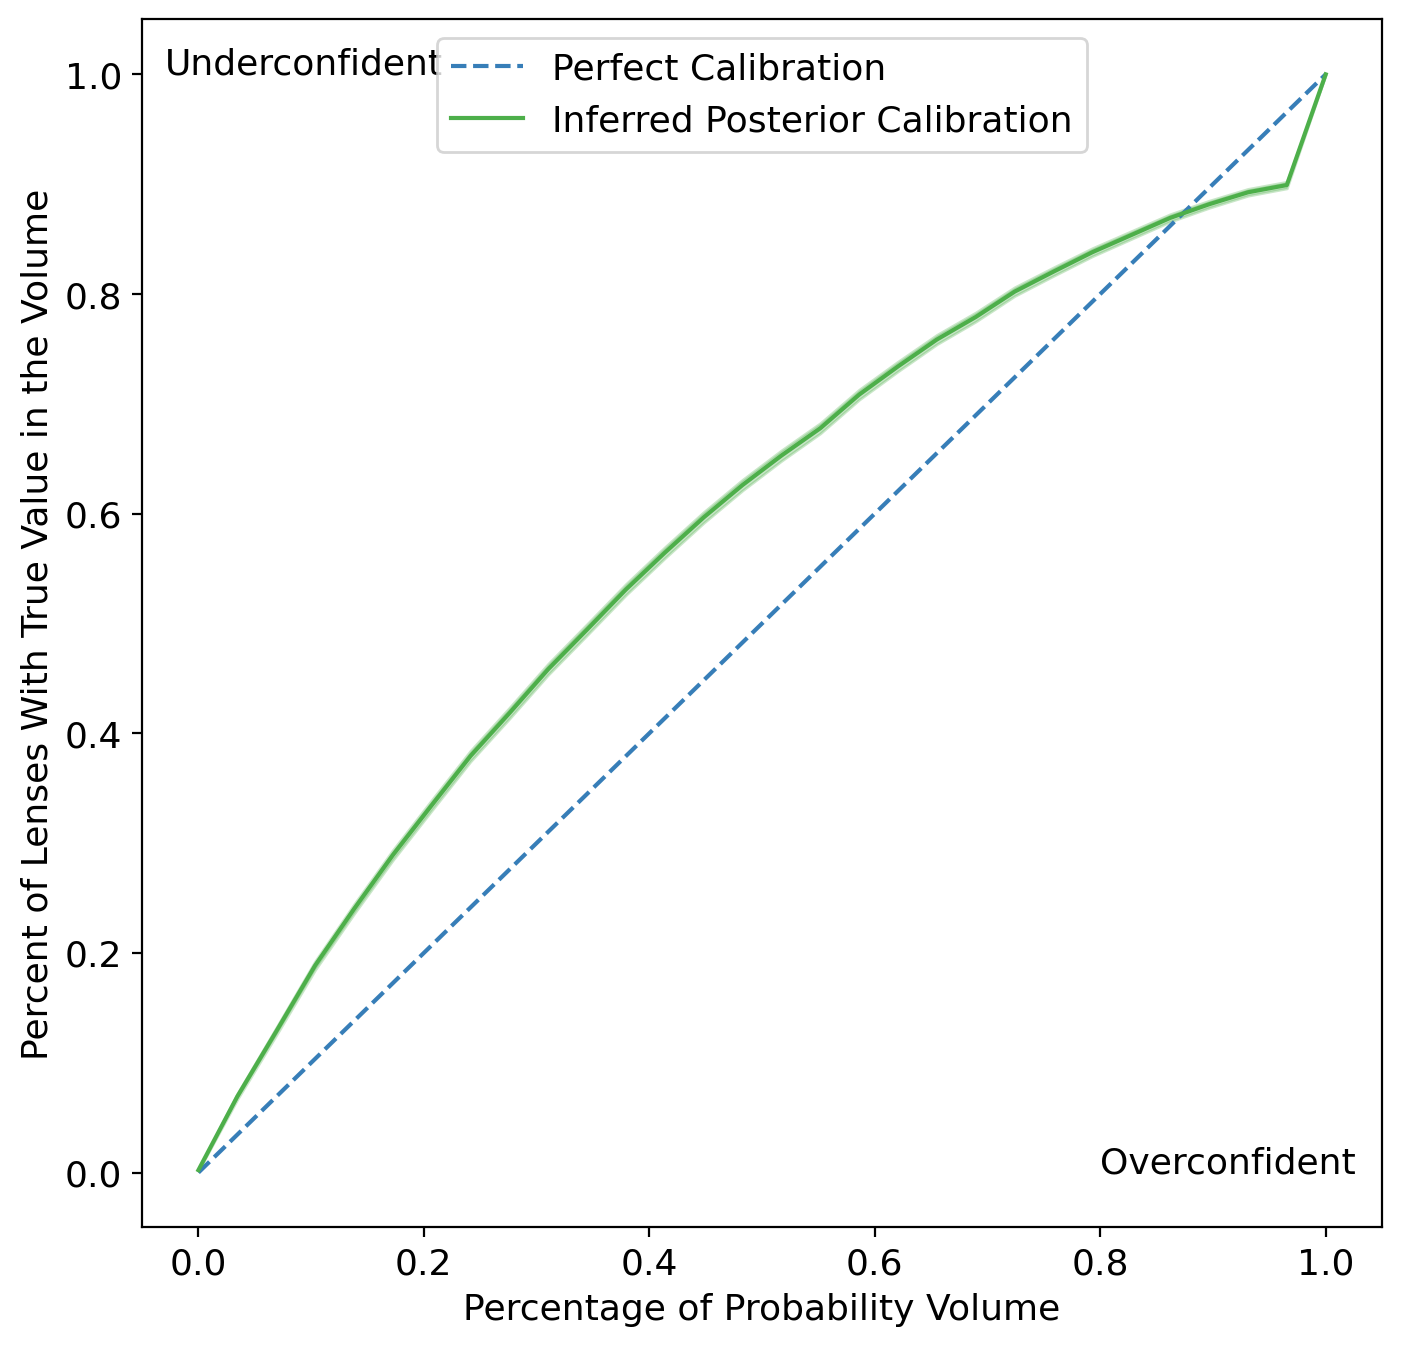

FileNotFoundError: [Errno 2] No such file or directory: '../paper/figures/appendix/biv_corn.pdf'

In [14]:
# Estimate a single Gaussian from the multimodal data.
data_means = [np.ones(2)*3,np.zeros(2)]
data_covs = [np.array([[0.4,0],[0,0.4]]),np.array([[0.4,0],[0,0.4]])]
ps = [0.9,0.1]
toy_batch_size = 10000
n_draws = 1000

data = []
for dmi in range(len(data_means)):
    data.append(np.random.multivariate_normal(data_means[dmi],data_covs[dmi],(toy_batch_size//len(
    data_mean))))
data = np.concatenate(data,axis=0)

post_mean = np.mean(data,axis=0)
post_cov=np.diag(np.std(data,axis=0))
post_fig, cal_fig = plot_toy_model_calibration_gm(data_means,data_covs,post_mean,post_cov,toy_batch_size,
                                                  ps,n_draws,fit_guass_data=True)
post_fig.savefig('../paper/figures/appendix/biv_corn.pdf')
cal_fig.savefig('../paper/figures/appendix/biv_cal.pdf')

Interestingly, the multimodal data leads to both under and over confidence by our network. In the interior region, corresponding to the principle mode, the toy prediction is has slightly too large covariances. In the tails, where our second mode becomes relevant, our single Gaussian prediction is suddenly very underconfident (since it assigns almost no weight to the second mode).